In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
sns.set()
%matplotlib inline 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
train_data = pd.read_csv('../data/metadata/train.csv')
test_data = pd.read_csv('../data/metadata/test.csv')
submission = pd.read_csv("../data/metadata/sample_submission.csv")

## Data size and content

In [6]:
print("Training data size",train_data.shape)
print("test data size",test_data.shape)
submission.head()

Training data size (1225029, 3)
test data size (117703, 2)


,id,landmarks
0,000088da12d664db,8815 0.03
1,0001623c6d808702,7249 0.61
2,0001bbb682d45002,5328 0.5
3,0002362830cfe3a3,4188 0.96
4,000270c9100de789,10506 0.82


In [7]:
train_data.head()

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


In [8]:
test_data.head()

,id,url
0,000088da12d664db,https://lh3.googleusercontent.com/-k45wfamuhT8...
1,0001623c6d808702,https://lh3.googleusercontent.com/-OQ0ywv8KVIA...
2,0001bbb682d45002,https://lh3.googleusercontent.com/-kloLenz1xZk...
3,0002362830cfe3a3,https://lh3.googleusercontent.com/-N6z79jNZYTg...
4,000270c9100de789,https://lh3.googleusercontent.com/-keriHaVOq1U...


In [9]:
n_train = len(train_data.id.unique())
n_test = len(test_data.id.unique())
n_landmarks = len(train_data.landmark_id.unique())
n_total = len(train_data.id.unique()) + len(test_data.id.unique())
concatenated_ids = pd.concat([train_data.id, test_data.id])
n_images = len(concatenated_ids.unique())
print('Number of landmarks in the dataset:', n_landmarks)
print('Number of unique images in the training set:', n_train)
print('Number of unique images in the test set:', n_test)
print('Total images in the dataset:', n_total)
print('Percentage of training data:', n_train*100./n_total)
print('Percentage of training data:', n_test*100./n_total)
print("Number of duplicates between test and training set:", n_train+n_test-n_images)

Number of landmarks in the dataset: 14951
Number of unique images in the training set: 1225029
Number of unique images in the test set: 117703
Total images in the dataset: 1342732
Percentage of training data: 91.23406606828466
Percentage of training data: 8.765933931715338
Number of duplicates between test and training set: 0


## Check for missing data

In [10]:
missing = train_data.isnull().sum()
all_val = train_data.count()

missing_train_df = pd.concat([missing, all_val], axis=1, keys=['Missing', 'All'])
missing_train_df

,Missing,All
id,0,1225029
url,0,1225029
landmark_id,0,1225029


In [11]:
missing = test_data.isnull().sum()
all_val = test_data.count()

missing_test_df = pd.concat([missing, all_val], axis=1, keys=['Missing', 'All'])
missing_test_df

,Missing,All
id,0,117703
url,0,117703


No missing points from training or test

## Top landmarks

In [12]:
def Top_ids(data, k=10):
    temp = data.landmark_id.value_counts().head(k)
    return list(temp.index)

In [13]:
# Top 5 landmarks
Top_ids(train_data, 5)

[9633, 6051, 6599, 9779, 2061]

In [22]:
# Top landmarks with counts
temp = pd.DataFrame(train_data.landmark_id.value_counts().head(10))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp['count'].sum()

203732

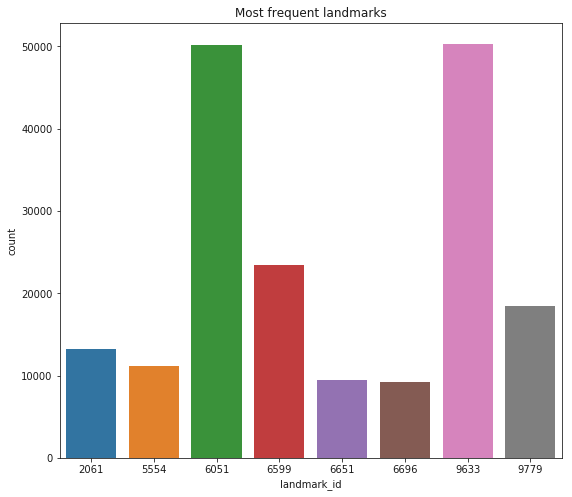

In [32]:
# Histogram of most common ids
plt.figure(figsize = (9, 8))
plt.title('Most frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,
            label="Count")
plt.show()

## Least common landmarks

In [37]:
train_data.landmark_id.value_counts().tail(10)

10007    1
2683     1
4753     1
6261     1
4144     1
1527     1
6025     1
4334     1
5865     1
8381     1
Name: landmark_id, dtype: int64

In [43]:
print('Number of landmarks with only 1 image:', sum(train_data.landmark_id.value_counts() == 1))
print('Number of landmarks with less than 100 images:', sum(train_data.landmark_id.value_counts() < 10))

Number of landmarks with only 1 image: 159
Number of landmarks with less than 100 images: 6165


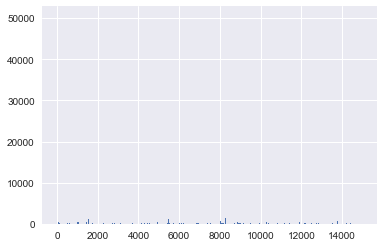

In [52]:
limits = [10, 50, 100, 1000, 10000]


Text(0,0.5,'Samples')

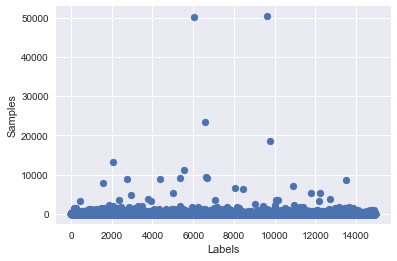

In [53]:
plt.scatter(train_data.landmark_id.value_counts().index.tolist(), train_data.landmark_id.value_counts().values.tolist())
plt.xlabel('Labels')
plt.ylabel('Samples')

## Close look at the images

In [56]:
def displayLandmarkImages(urls):
    
    imageStyle = "height: 60px; margin: 2px; float: left; border: 1px solid blue;"
    imagesList = ''.join([f"<img style='{imageStyle}' src='{u}' />" for _, u in urls.iteritems()])

    display(HTML(imagesList))
    
    
def displayLandmarkImagesLarge(urls):
    
    imageStyle = "height: 100px; margin: 2px; float: left; border: 1px solid blue;"
    imagesList = ''.join([f"<img style='{imageStyle}' src='{u}' />" for _, u in urls.iteritems()])

    display(HTML(imagesList))

In [58]:
IMAGES_NUMBER = 50
landmarkId = train_data['landmark_id'].value_counts().keys()[5]
urls = train_data[train_data['landmark_id'] == landmarkId]['url'].head(IMAGES_NUMBER)
displayLandmarkImages(urls)

In [59]:
LANDMARK_NUMBER = 5
IMAGES_NUMBER = 5
landMarkIDs = pd.Series(train_data['landmark_id'].value_counts().keys())[1:LANDMARK_NUMBER+1]
for landMarkID in landMarkIDs:
    url = train_data[train_data['landmark_id'] == landMarkID]['url'].head(IMAGES_NUMBER)
    displayLandmarkImagesLarge(url)